In [28]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

##  Read data files

In [29]:
dataset = []
features = None

for file in os.listdir('../data/sepsis_data/'):

    # Read file
    with open('../data/sepsis_data/%s' % (file)) as f:

        if not features:
            features = f.readline().rstrip('\n').split('|')
        else:
            # This skips the headers
            f.readline()

        for idx, line in enumerate(f):
            pid = file.split('.')[0]
            line = line.rstrip('\n')
            dataset.append([pid] + line.split('|'))

dataset = np.array(dataset)

In [30]:
dataset.shape

(188453, 42)

## Exploratory Analysis

In [31]:
dataset = pd.DataFrame(dataset, columns=['pid'] + features)

In [32]:
dataset.head()

,pid,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,p01065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,54,1,1,0,-5.76,1,0
1,p01065,83,100,NaN,103,68,58,NaN,NaN,NaN,...,NaN,NaN,NaN,54,1,1,0,-5.76,2,0
2,p01065,80,99,36.7,103,69,58,10,NaN,NaN,...,NaN,NaN,NaN,54,1,1,0,-5.76,3,0
3,p01065,87,99,NaN,107,76,67,NaN,NaN,NaN,...,NaN,NaN,NaN,54,1,1,0,-5.76,4,0
4,p01065,91,99,NaN,106,76,68,NaN,NaN,NaN,...,NaN,NaN,NaN,54,1,1,0,-5.76,5,0


In [33]:
dataset = pd.concat([dataset.pid, dataset.loc[:,"HR":"SepsisLabel"].astype(np.float)], axis=1)

In [34]:
# dataset.fillna(value=0, inplace=True)

In [35]:
features

['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'EtCO2',
 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Alkalinephos',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Magnesium',
 'Phosphate',
 'Potassium',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Fibrinogen',
 'Platelets',
 'Age',
 'Gender',
 'Unit1',
 'Unit2',
 'HospAdmTime',
 'ICULOS',
 'SepsisLabel']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


KeyboardInterrupt: 

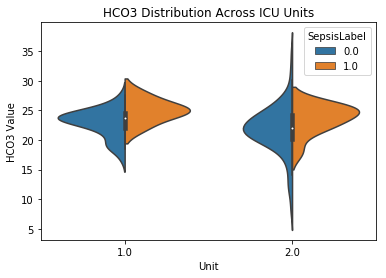

In [36]:
# Create violin plots
for f in features[0:34]:
    f_data = dataset[[f, 'Unit1', 'Unit2', 'Gender', 'SepsisLabel']].dropna()
    f_data['Unit'] = f_data['Unit1'].replace(0, 2)
    f_data.drop(columns=['Unit1', 'Unit2'], inplace=True)
    
    plt.figure(1)
    sns.violinplot(x='Unit', y=f, data=f_data, hue='SepsisLabel', split=True)
    plt.title("%s Distribution Across ICU Units"%f)
    plt.ylabel("%s Value"%f)
    plt.savefig('../plots/%s_distr_unit'%f)
    plt.close()
    
    plt.figure(2)
    sns.violinplot(x='Gender', y=f, data=f_data, hue='SepsisLabel', split=True)
    plt.title("%s Distribution Across Gender"%f)
    plt.ylabel("%s Value"%f)
    plt.savefig('../plots/%s_distr_gender'%f)
    plt.close()
    

In [ ]:
# Create histograms
for f in features:
    data = dataset[['pid', f, 'Unit1', 'Unit2', 'Gender', 'SepsisLabel']]
    sep_data = data.groupby('pid').filter(lambda x: x['SepsisLabel'].any() == 1)
    nonsep_data = data.groupby('pid').filter(lambda x: x['SepsisLabel'].sum() == 0)
    
    before_sep = []
    after_sep = []
    for pid, df in sep_data.groupby('pid'):
        df.reset_index(drop=True, inplace=True)
        
        first_idx = df['SepsisLabel'].idxmax()
        before_sep.extend(df.iloc[0:(first_idx+6)][[f, 'SepsisLabel']].values)
        after_sep.extend(df.iloc[(first_idx+6):][[f, 'SepsisLabel']].values)
    
    before_sep = np.array(before_sep, dtype=np.float)
    after_sep = np.array(after_sep, dtype=np.float)
    nonsep = nonsep_data[f].values
    break

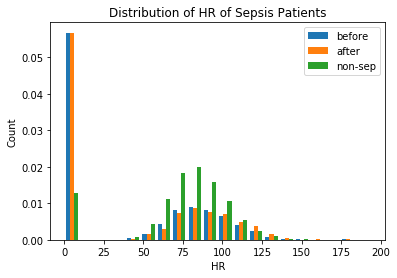

In [182]:
plt.hist([before_sep,after_sep,nonsep], bins=20, label=['before', 'after', 'non-sep'], density=True)
plt.title("Distribution of HR of Sepsis Patients")
plt.legend(loc=1, labels=['before', 'after', 'non-sep'])
plt.xlabel("%s"%f)
plt.ylabel("Count")
plt.savefig('../HR_distr')
plt.show()

### 1. Figure out number of patients with sepsis 

In [37]:
patient_df[patient_df.SepsisLabel == 1]['pid'].unique().shape

NameError: name 'patient_df' is not defined

In [38]:
mimic_patient_df[mimic_patient_df['sepsis-3'] == 1]['hadm_id'].unique().shape

NameError: name 'mimic_patient_df' is not defined

In [15]:
mimic_patient_df.hadm_id.unique().shape

(11791,)

## In MIMIC-III sepsis df, half the patients have sepsis. 

### 2. Number of Septic patients between Units

In [ ]:
patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Unit1 == 1)]['pid'].unique().shape

Unit 1: 88 septic patients 

Unit 2: 191 septic patients

### Male Female Ratio

In [16]:
patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Gender == 0)]['pid'].unique().shape

(122,)

122 are female and 157 are male

In [17]:
patient_df[(patient_df.Gender == 0)]['pid'].unique().shape

(2295,)

### Age Range of Septic Patients Between ICUs

In [18]:
ages = patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Unit1 == 1)]['Age'].unique()

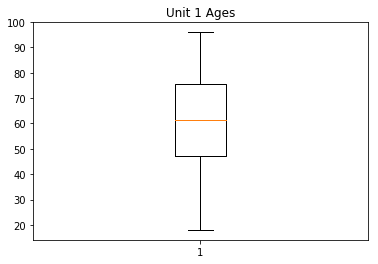

In [19]:
plt.boxplot(ages)
plt.title("Unit 1 Ages")
plt.show()

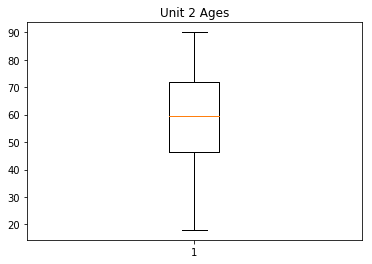

In [20]:
plt.boxplot(patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Unit2 == 1)]['Age'].unique())
plt.title("Unit 2 Ages")
plt.show()


## Let's look at degree of missingness

In [173]:
# Entire dataset
plt.figure(figsize=(15,5))
plt.bar(dataset.isna().sum().index, dataset.isna().sum().values)
plt.title("Missingness per column")
plt.xticks(rotation=90)
plt.figure
plt.show()

AttributeError: 'Dataset' object has no attribute 'isna'

<Figure size 1080x360 with 0 Axes>

In [176]:
u1_patients = data[data.Unit1 == 1]
u2_patients = data[data.Unit2 == 1]

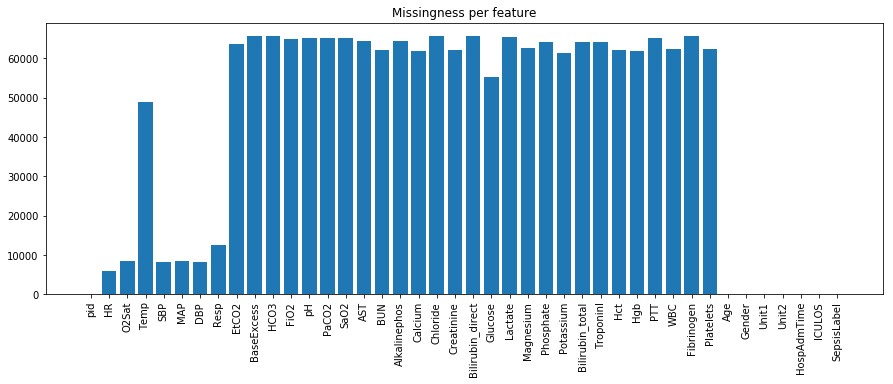

In [180]:
u1_na_count = data.isna().sum()
plt.figure(figsize=(15,5))
plt.bar(u1_na_count.index, u1_patients.isna().sum().values)
plt.title("Missingness per feature")
plt.xticks(rotation=90)
plt.figure
plt.show()

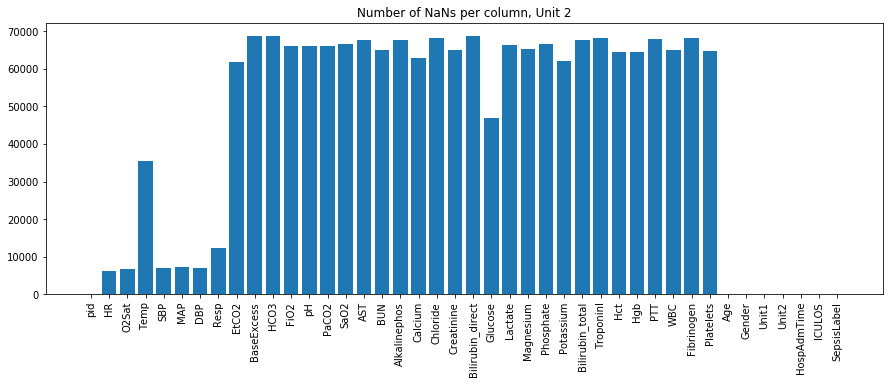

In [179]:
u2_na_count = u2_patients.isna().sum()
plt.figure(figsize=(15,5))
plt.bar(u1_na_count.index, u2_patients.isna().sum().values)
plt.title("Number of NaNs per column, Unit 2")
plt.xticks(rotation=90)
plt.show()

### Missingness in Unit 1 is a little more than Unit 2 in 2 specific columns

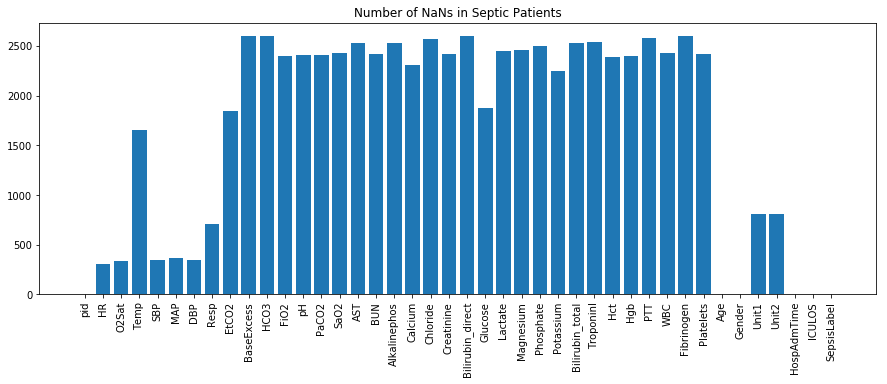

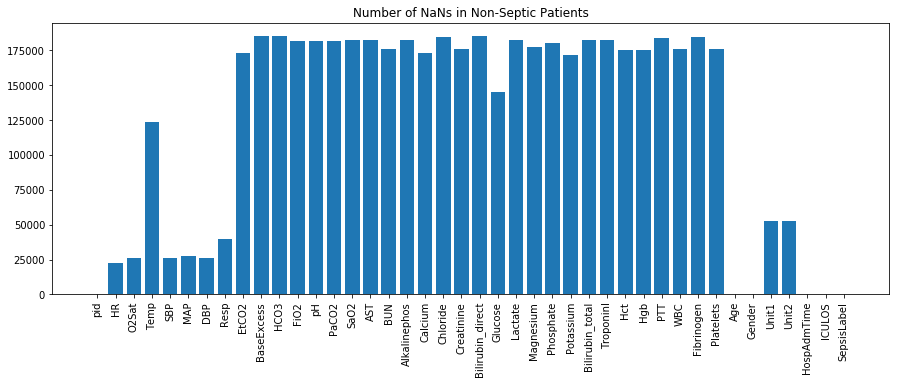

In [119]:
# Across Septic and Non-Septic patients
septic_df = dataset[dataset.SepsisLabel == 1]
nonsep_df = dataset[dataset.SepsisLabel == 0]

sep_na_count = septic_df.isna().sum()
plt.figure(figsize=(15,5))
plt.bar(sep_na_count.index, sep_na_count.values)
plt.title("Number of NaNs in Septic Patients")
plt.xticks(rotation=90)
plt.show()

nonsep_na_count = nonsep_df.isna().sum()
plt.figure(figsize=(15,5))
plt.bar(nonsep_na_count.index, nonsep_na_count.values)
plt.title("Number of NaNs in Non-Septic Patients")
plt.xticks(rotation=90)
plt.show()

### What is the distribution of time steps across septic patients and non-septic patients

In [185]:
pos_time_agg = patient_df.groupby('pid').filter(lambda x: x['SepsisLabel'].any())
neg_time_agg = patient_df.groupby('pid').filter(lambda x: x['SepsisLabel'].sum() == 0)

In [177]:
time_agg.groupby('pid').ICULOS.agg(['count'])['count'].min(), time_agg.groupby('pid').ICULOS.agg(['count'])['count'].max()

(8, 336)

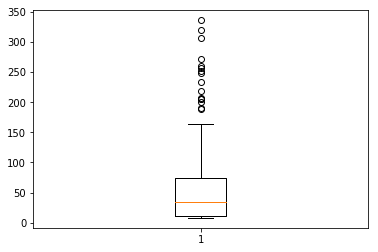

In [179]:
plt.boxplot(time_agg.groupby('pid').ICULOS.agg(['count'])['count'])
plt.show()

In [182]:
time_agg = 
time_agg['count'].min(), time_agg['count'].max()

(15524, 15524)

In [183]:
(time_agg['count'] > 30).sum()

1

{'boxes': [<matplotlib.lines.Line2D at 0x16526a6a0>],
 'caps': [<matplotlib.lines.Line2D at 0x16526ae80>,
 'fliers': [<matplotlib.lines.Line2D at 0x165f1c898>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x165f1c550>],
 'whiskers': [<matplotlib.lines.Line2D at 0x16526a7f0>,
  <matplotlib.lines.Line2D at 0x16526ab38>]}

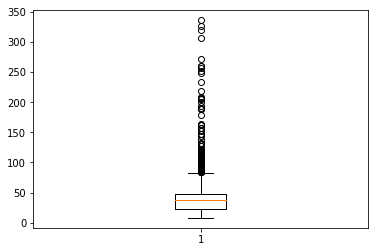

In [154]:
plt.boxplot(time_agg['count'])

In [49]:
import sys
sys.path.append('../')
sys.path.append('../datautils')
from datautils import dataset

In [50]:
dataset = dataset.Dataset('../data/sepsis_data',maxLength=336)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
m = np.mean(dataset.train_data.x_lengths)
m

37.6795

In [104]:
matrix = np.sum(dataset.train_data.m[0:50,:,:],axis=1)/np.reshape(dataset.train_data.x_lengths[0:50],[-1,1])

array([104., 104.,  33., 103., 104., 103.,  45.,  69.,   0.,   0.,   3.,
         2.,   2.,   2.,   9.,   9.,   9.,  10.,   0.,   9.,   0.,  46.,
         1.,   5.,   5.,  10.,   9.,   0.,  10.,  10.,   9.,  10.,   9.,
        10., 107., 107.])

In [105]:
np.reshape(dataset.train_data.x_lengths[0:50],[-1,1])
dataset.train_data.files[0:50]
dataset.train_data.m[0:3].sum(axis=1)[2]

array([104., 104.,  33., 103., 104., 103.,  45.,  69.,   0.,   0.,   3.,
         2.,   2.,   2.,   9.,   9.,   9.,  10.,   0.,   9.,   0.,  46.,
         1.,   5.,   5.,  10.,   9.,   0.,  10.,  10.,   9.,  10.,   9.,
        10., 107., 107.])

([<matplotlib.axis.XTick at 0x1d5c73a58>,
 <a list of 50 Text xticklabel objects>)

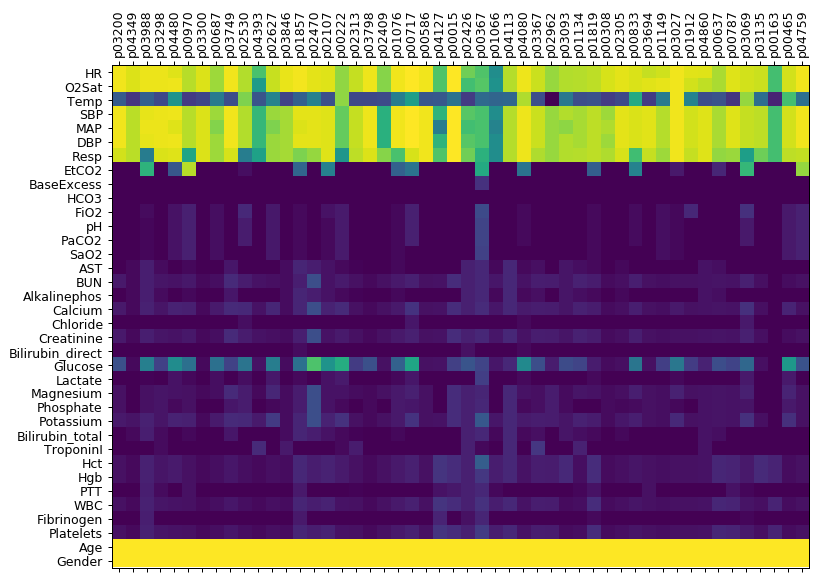

In [115]:
fig = plt.figure(figsize=(10, 8), dpi=90)
ax = fig.add_subplot(111)
ax.matshow(matrix.T,cmap='viridis')
ax.set_yticklabels(dataset.train_data.features.keys())
ax.set_xticklabels([x[:-4] for x in dataset.train_data.files[0:50]])
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 36, step=1))
plt.xticks(np.arange(0, 50, step=1))

In [103]:
data = []
features = None

for file in os.listdir('../data/sepsis_data/'):

    # Read file
    with open('../data/sepsis_data/%s' % (file)) as f:

        if not features:
            features = f.readline().rstrip('\n').split('|')
        else:
            # This skips the headers
            f.readline()

        for idx, line in enumerate(f):
            pid = file.split('.')[0]
            line = line.rstrip('\n')
            data.append([pid] + line.split('|'))

data = np.array(data)

data = pd.DataFrame(data, columns=['pid'] + features)


In [158]:
plt.figure(1)
pltfeat=['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'EtCO2',
 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Alkalinephos',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Magnesium',
 'Phosphate',
 'Potassium',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Fibrinogen',
 'Platelets',
 'Age',
 'Gender']
data=data.convert_objects(convert_numeric=True)

fdata=data[features]
fdata[pltfeat]=(fdata[pltfeat]-fdata[pltfeat].mean())/fdata[pltfeat].std()
fdata=pd.melt(fdata, value_vars=['Temp','HCO3','AST','BUN','Chloride','Creatinine','TroponinI','Fibrinogen'], id_vars='SepsisLabel')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


<Figure size 432x288 with 0 Axes>

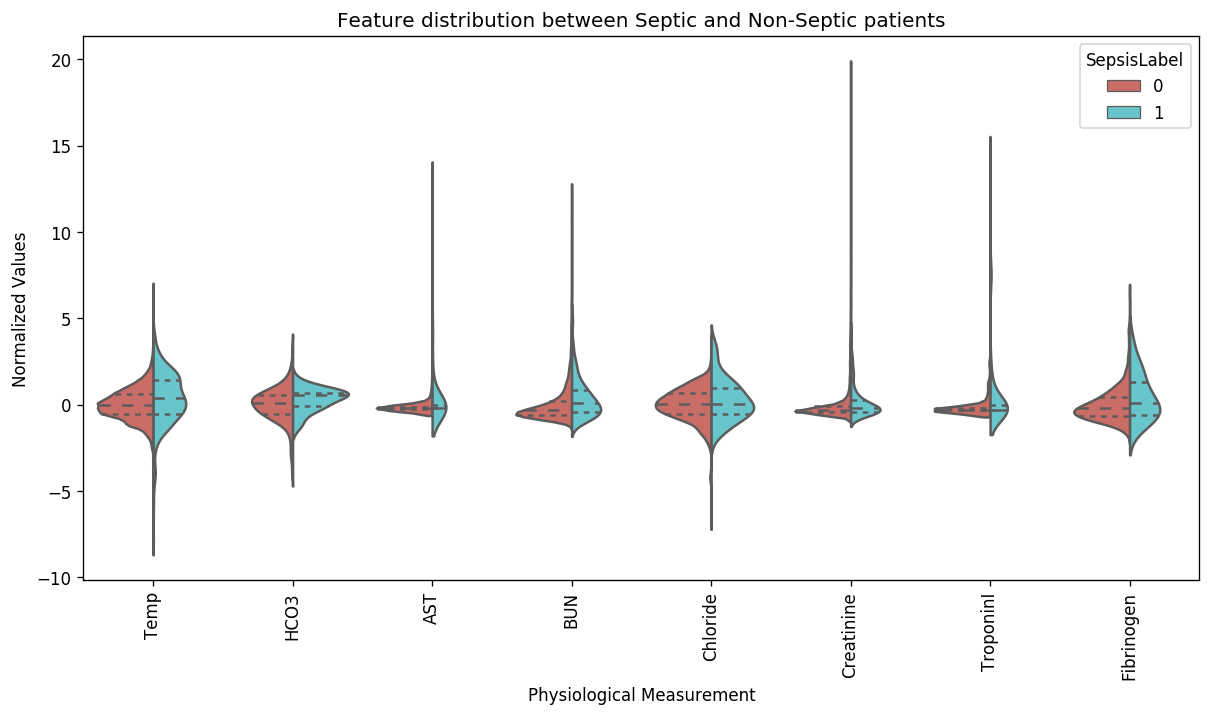

In [192]:
fig = plt.figure(figsize=(12, 6), dpi=120)
ax = fig.add_subplot(111)
plt.xticks(rotation=90)

sns.violinplot(x='variable',y='value',data=fdata, hue='SepsisLabel', palette="hls",split=True,dropna=True, inner="quartile")
plt.title("Feature distribution between Septic and Non-Septic patients")
plt.ylabel("Normalized Values")
plt.xlabel("Physiological Measurement")
plt.show()

In [150]:
fdata.head()

,SepsisLabel,variable,value
0,-0.118806,HR,NaN
1,-0.118806,HR,-0.062908
2,-0.118806,HR,-0.231208
3,-0.118806,HR,0.161493
4,-0.118806,HR,0.385893


([<matplotlib.axis.XTick at 0x1d47b93c8>,
 <a list of 30 Text xticklabel objects>)

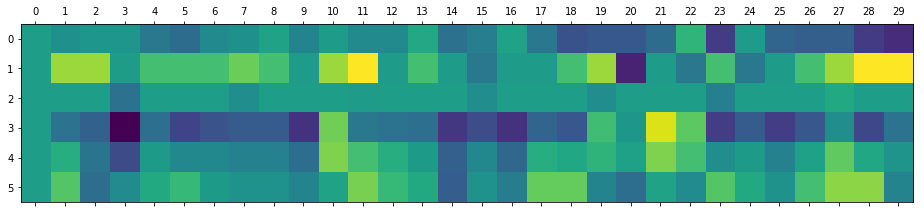

In [125]:
plt.matshow(dataset.train_data.x[3][0:30,0:6].T)
plt.yticks(np.arange(0, 6, step=1))
plt.xticks(np.arange(0, 30, step=1))

In [1]:
!ls

DataVisualization.ipynb       baseline.py
ExploratoryDataAnalysis.ipynb sliding_window_models.py
SlidingWindowBaselines.ipynb
